In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix,f1_score
from tensorflow import keras
import cv2
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.vgg16 import VGG16
import keras_tuner as kt
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h3>Retrieving all the files name using glob.glob function<h3>

In [3]:
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

In [3]:
len(breast_img)

277524

In [4]:
breast_img[5:10]

['/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png',
 '/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png',
 '/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x701_y651_class0.png',
 '/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x951_y1401_class0.png',
 '/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x601_y501_class0.png']

## Extracting images in arrays of arrays format and equalizing the number of cancerous and non- cancerous


In [4]:
data=[]
label=[]
c=0
b=0
for i in breast_img:
      a=cv2.imread(i,cv2.IMREAD_COLOR)
      a=cv2.resize(a, (224, 224), interpolation = cv2.INTER_LINEAR)
      if i[-5]=='0' and b<=5000:
        label.append(0)
        data.append(a)
        b+=1
      elif  i[-5]=='1' and c<=5000:
        label.append(1)
        data.append(a) 
        c+=1
     
      if b>=5000 and c>=5000:
        break
        

In [5]:
data=np.array(data)
label=np.array(label)

<h4>Shape of our data<h4>

In [7]:
data.shape,label.shape

((10001, 224, 224, 3), (10001,))

In [8]:
data[0],label[0]

(array([[[161, 109, 205],
         [161, 109, 205],
         [163, 112, 206],
         ...,
         [132,  78, 132],
         [130,  76, 129],
         [130,  76, 129]],
 
        [[161, 109, 205],
         [161, 109, 205],
         [163, 111, 206],
         ...,
         [132,  78, 132],
         [130,  76, 129],
         [130,  76, 129]],
 
        [[161, 110, 205],
         [161, 110, 205],
         [163, 112, 206],
         ...,
         [134,  80, 135],
         [132,  78, 131],
         [132,  78, 131]],
 
        ...,
 
        [[150, 103, 154],
         [150, 103, 154],
         [149, 101, 152],
         ...,
         [200, 173, 223],
         [201, 174, 224],
         [201, 174, 224]],
 
        [[148, 101, 152],
         [148, 101, 152],
         [147,  99, 150],
         ...,
         [200, 173, 223],
         [201, 174, 224],
         [201, 174, 224]],
 
        [[148, 101, 152],
         [148, 101, 152],
         [147,  99, 150],
         ...,
         [200, 173, 223],
  

<h4>Number of cancerous and non-cancerous patients<h4>

In [9]:
unique_values, counts = np.unique(label, return_counts=True)
for i in range(len(counts)):
  print(unique_values[i],counts[i])

0 5001
1 5000


In [10]:
unique_values=['Non IDC','IDC']


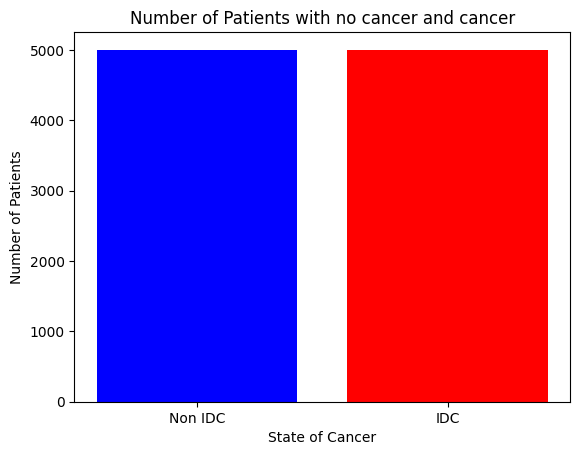

In [11]:
plt.bar(unique_values,counts,color=['Blue','red'])
# Adding labels and a title
plt.xlabel('State of Cancer')
plt.ylabel('Number of Patients')
plt.title('Number of Patients with no cancer and cancer')

# Display the bar chart
plt.show()

<h4>Display of some images data<h4>

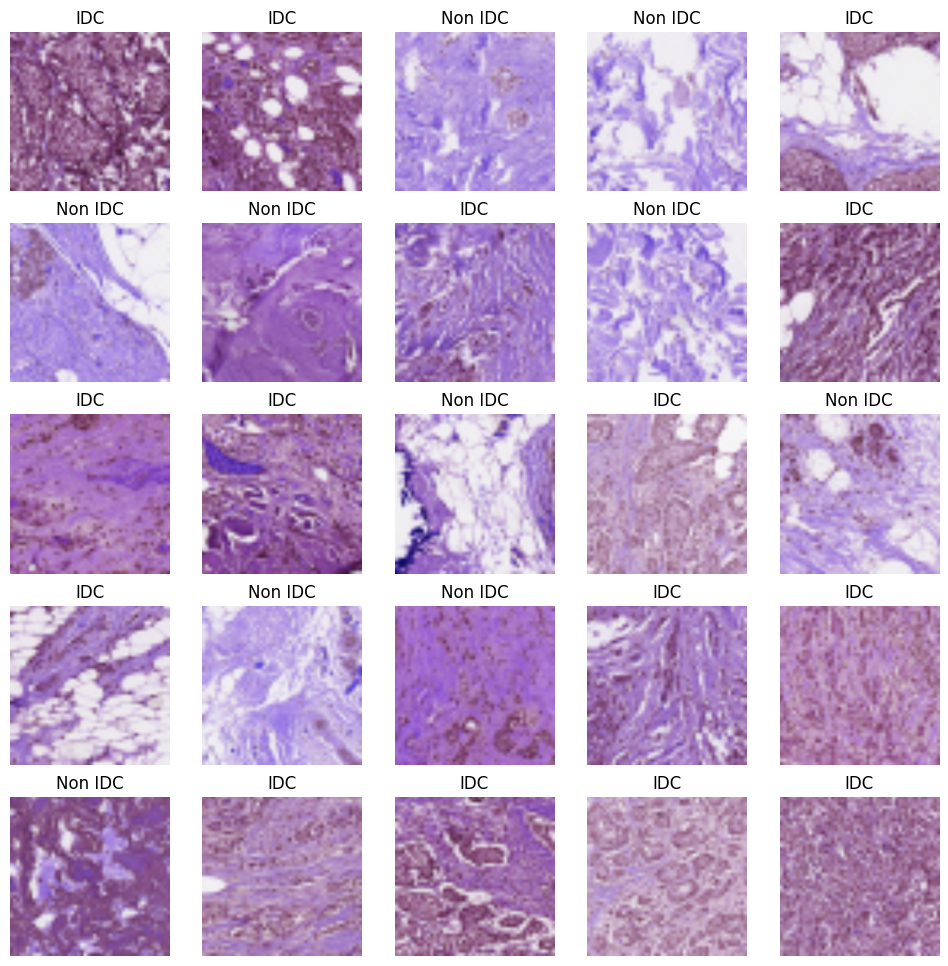

In [12]:
# Create a figure with 5 rows and 5 columns to display 25 images
sh = np.random.randint(0, len(label),25)
fig = plt.figure(figsize=(12, 12))
s=1
for i in sh:
    plt.subplot(5, 5, s)
    plt.imshow(data[i])
    if label[i]==0:
     plt.title('Non IDC')
    else:
     plt.title('IDC')
    plt.axis('off')
    s+=1


# Show the plot
plt.show()

<h4>Splitting the data into test and train<h4>

In [6]:
x_train,x_test,y_train,y_test=train_test_split(data,label,random_state=78,test_size=0.25)

In [14]:
unique_values, counts = np.unique(y_test, return_counts=True)
for i in range(len(counts)):
  print(unique_values[i],counts[i])

0 1270
1 1231


In [15]:
x_test.shape,y_train.shape


((2501, 224, 224, 3), (7500,))

<h4> Converting categorical data into a one-hot encoded format,One-hot encoding is a way to represent categorical variables with binary vectors.<h4>

In [7]:
y_train=tf.one_hot(y_train,2)
y_test=tf.one_hot(y_test,2)

In [17]:
y_train

<tf.Tensor: shape=(7500, 2), dtype=float32, numpy=
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)>

## Using Keras-Tuner

In [18]:
def build_model(hp):
    model = keras.Sequential()
    c=0
    # Add convolutional layers
    for i in range(hp.Int('convolayer', 3, 8)):
        if c == 0:
            model.add(keras.layers.Conv2D(filters=hp.Int('Filter' + str(i), 32,128, step=32),
                                          kernel_size=3,
                                          padding='same',
                                          activation='relu',
                                          input_shape=(224, 224, 3)))
            model.add(keras.layers.MaxPooling2D((2, 2),padding="VALID",strides =2))
        else:
            model.add(keras.layers.Conv2D(filters=hp.Int('Filter' + str(i), 32, 128, step=32),
                                          kernel_size=3,
                                          padding='same',
                                          activation='relu'))
            model.add(keras.layers.MaxPooling2D((2, 2),padding="VALID",strides =2))

        c=c+1
    model.add(keras.layers.Flatten())
    # Add dense layers

    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(2, activation='softmax'))
    # Compile the model
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [19]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=5,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [20]:
tuner.search(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

Trial 5 Complete [00h 01m 29s]
val_accuracy: 0.7924830317497253

Best val_accuracy So Far: 0.8284686207771301
Total elapsed time: 00h 03m 38s


In [21]:
best_hyperparameter = tuner.get_best_hyperparameters()[0].values
best_hyperparameter

{'convolayer': 6,
 'Filter0': 64,
 'Filter1': 128,
 'Filter2': 128,
 'Filter3': 32,
 'Filter4': 32,
 'Filter5': 32}

In [22]:
best_model=tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 128)       0

In [23]:
history1=best_model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 12, initial_epoch=3, batch_size = 75)

Epoch 4/12
100/100 [==============================] - 28s 212ms/step - loss: 0.3949 - accuracy: 0.8240 - val_loss: 0.4146 - val_accuracy: 0.8205
Epoch 5/12
100/100 [==============================] - 19s 195ms/step - loss: 0.3861 - accuracy: 0.8305 - val_loss: 0.3689 - val_accuracy: 0.8409
Epoch 6/12
100/100 [==============================] - 19s 195ms/step - loss: 0.3609 - accuracy: 0.8443 - val_loss: 0.3290 - val_accuracy: 0.8577
Epoch 7/12
100/100 [==============================] - 19s 195ms/step - loss: 0.3525 - accuracy: 0.8472 - val_loss: 0.3625 - val_accuracy: 0.8477
Epoch 8/12
100/100 [==============================] - 19s 194ms/step - loss: 0.3493 - accuracy: 0.8475 - val_loss: 0.3285 - val_accuracy: 0.8509
Epoch 9/12
100/100 [==============================] - 19s 194ms/step - loss: 0.3351 - accuracy: 0.8560 - val_loss: 0.3211 - val_accuracy: 0.8549
Epoch 10/12
100/100 [==============================] - 19s 194ms/step - loss: 0.3417 - accuracy: 0.8532 - val_loss: 0.3138 - val_a

In [24]:
y_pred=best_model.predict(x_test)
y_pred_max=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis = 1)

79/79 [==============================] - 2s 21ms/step


In [25]:
accuracy1=accuracy_score(y_true,y_pred_max)
precision1=precision_score(y_true,y_pred_max)
recall1=recall_score(y_true,y_pred_max)
f1score1=f1_score(y_true,y_pred_max)

In [26]:
print("Precision of keras-tuner is:",precision1)
print("Accuracy of keras-tuner is:",accuracy1)
print("Recall of keras-tuner is:",recall1)
print("F1 Score of keras-tuner is:",f1score1)

Precision of keras-tuner is: 0.8783894823336073
Accuracy of keras-tuner is: 0.8760495801679328
Recall of keras-tuner is: 0.8683996750609261
F1 Score of keras-tuner is: 0.8733660130718954


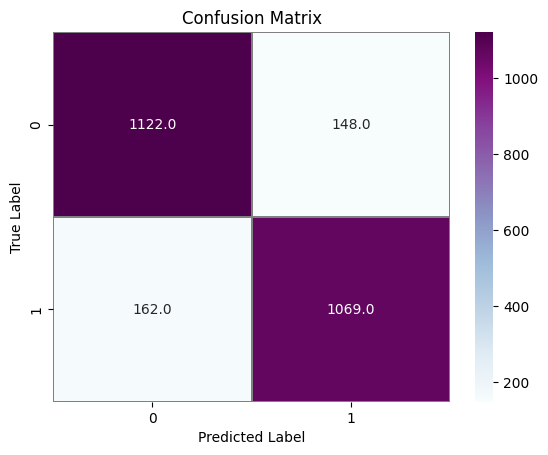

In [27]:
confusion_mtx = confusion_matrix(y_true,y_pred_max)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


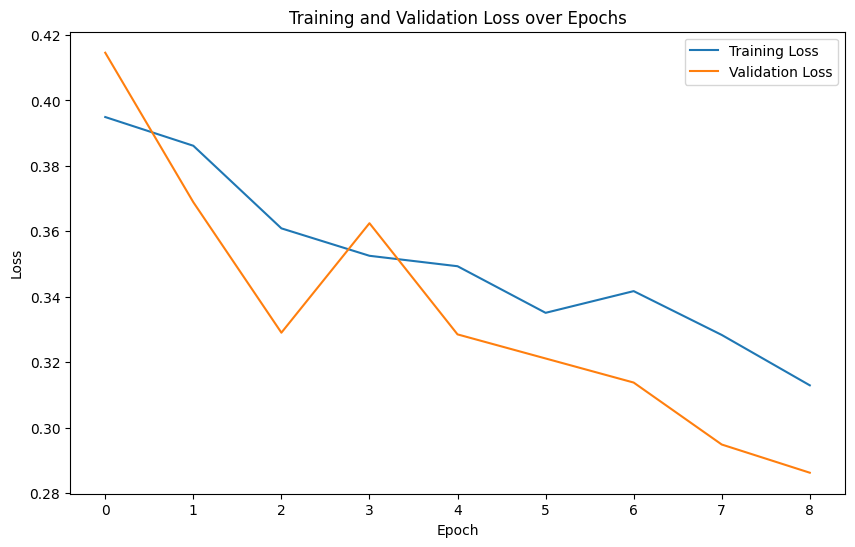

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

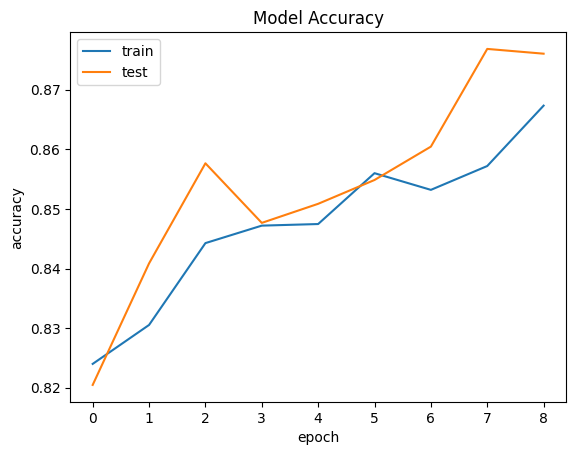

In [29]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Using VGG16 Model

In [30]:
base_model = VGG16(weights='imagenet', include_top=False,input_shape=(224,224,3))

58889256/58889256 [==============================] - 0s 0us/step


In [31]:
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

### Training new layers after VGG16

In [32]:
model = keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2, activation='softmax')
])


In [33]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
history2=model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, batch_size = 75)

Epoch 1/10
100/100 [==============================] - 52s 431ms/step - loss: 0.6577 - accuracy: 0.7775 - val_loss: 0.3616 - val_accuracy: 0.8341
Epoch 2/10
100/100 [==============================] - 38s 379ms/step - loss: 0.3414 - accuracy: 0.8485 - val_loss: 0.3742 - val_accuracy: 0.8553
Epoch 3/10
100/100 [==============================] - 38s 380ms/step - loss: 0.2849 - accuracy: 0.8660 - val_loss: 0.3455 - val_accuracy: 0.8577
Epoch 4/10
100/100 [==============================] - 38s 380ms/step - loss: 0.2347 - accuracy: 0.8895 - val_loss: 0.3869 - val_accuracy: 0.8537
Epoch 5/10
100/100 [==============================] - 38s 380ms/step - loss: 0.1959 - accuracy: 0.9053 - val_loss: 0.4067 - val_accuracy: 0.8509
Epoch 6/10
100/100 [==============================] - 38s 380ms/step - loss: 0.1724 - accuracy: 0.9151 - val_loss: 0.4299 - val_accuracy: 0.8513
Epoch 7/10
100/100 [==============================] - 38s 380ms/step - loss: 0.1494 - accuracy: 0.9263 - val_loss: 0.4371 - val_ac

In [35]:
y_pred=model.predict(x_test)
y_pred_max=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis = 1)

79/79 [==============================] - 13s 120ms/step


### All Metrics

In [36]:
accuracy2=accuracy_score(y_true,y_pred_max)
precision2=precision_score(y_true,y_pred_max)
recall2=recall_score(y_true,y_pred_max)
f1score2=f1_score(y_true,y_pred_max)

In [37]:
print("Precision of VGG16 model is:",precision2)
print("Accuracy  of VGG16 model is:",accuracy2)
print("Recall  of VGG16 model  is:",recall2)
print("F1 Score  of VGG16 model  is:",f1score2)

Precision of VGG16 model is: 0.8891774891774892
Accuracy  of VGG16 model is: 0.8672530987604958
Recall  of VGG16 model  is: 0.834281072298944
F1 Score  of VGG16 model  is: 0.8608549874266554


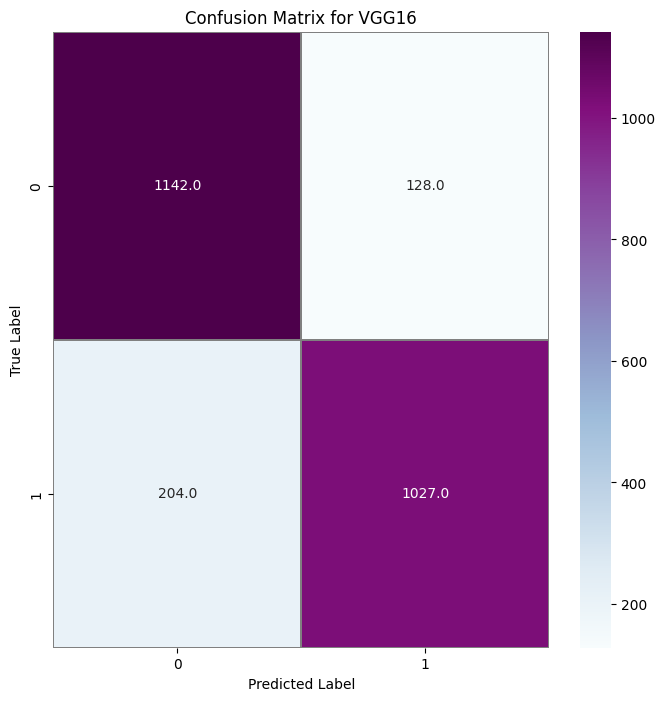

In [38]:
confusion_mtx = confusion_matrix(y_true, y_pred_max) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for VGG16")
plt.show()

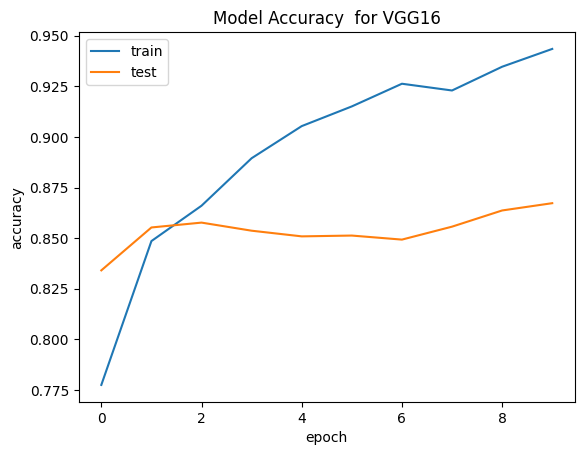

In [39]:
#Plotting training and validation accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy  for VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

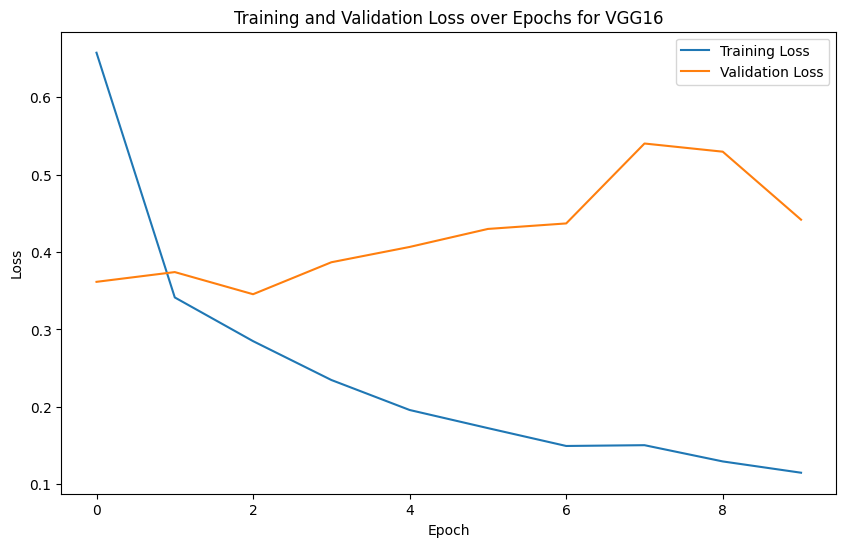

In [40]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs for VGG16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Using ResNet50 to improve accuracy

### Preprocessing data for our model

In [6]:
data1= preprocess_input(data)

### Data after preprocessing

In [7]:
data1[0],label[0]

(array([[[101.061    ,  -7.7789993,  37.32     ],
         [101.061    ,  -7.7789993,  37.32     ],
         [102.061    ,  -4.7789993,  39.32     ],
         ...,
         [ 28.060997 , -38.779    ,   8.32     ],
         [ 25.060997 , -40.779    ,   6.3199997],
         [ 25.060997 , -40.779    ,   6.3199997]],
 
        [[101.061    ,  -7.7789993,  37.32     ],
         [101.061    ,  -7.7789993,  37.32     ],
         [102.061    ,  -5.7789993,  39.32     ],
         ...,
         [ 28.060997 , -38.779    ,   8.32     ],
         [ 25.060997 , -40.779    ,   6.3199997],
         [ 25.060997 , -40.779    ,   6.3199997]],
 
        [[101.061    ,  -6.7789993,  37.32     ],
         [101.061    ,  -6.7789993,  37.32     ],
         [102.061    ,  -4.7789993,  39.32     ],
         ...,
         [ 31.060997 , -36.779    ,  10.32     ],
         [ 27.060997 , -38.779    ,   8.32     ],
         [ 27.060997 , -38.779    ,   8.32     ]],
 
        ...,
 
        [[ 50.060997 , -13.778999 

In [8]:
x_train,x_test,y_train,y_test=train_test_split(data1,label,random_state=78,test_size=0.25)

In [9]:
y_train=tf.one_hot(y_train,2)
y_test=tf.one_hot(y_test,2)

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False,input_shape=(224,224,3))

94765736/94765736 [==============================] - 0s 0us/step


In [11]:
# i.e. freeze all convolutional ResNet50 layers
for layer in base_model.layers:
    layer.trainable = False

In [12]:
model = keras.Sequential([
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2 ,activation='softmax')
])

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [14]:
history3=model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, batch_size = 75)

Epoch 1/10
100/100 [==============================] - 49s 326ms/step - loss: 1.1594 - accuracy: 0.8213 - val_loss: 0.3160 - val_accuracy: 0.8705
Epoch 2/10
100/100 [==============================] - 28s 276ms/step - loss: 0.2055 - accuracy: 0.9217 - val_loss: 0.3016 - val_accuracy: 0.8824
Epoch 3/10
100/100 [==============================] - 28s 283ms/step - loss: 0.1187 - accuracy: 0.9560 - val_loss: 0.3111 - val_accuracy: 0.8812
Epoch 4/10
100/100 [==============================] - 29s 290ms/step - loss: 0.0571 - accuracy: 0.9836 - val_loss: 0.3248 - val_accuracy: 0.8932
Epoch 5/10
100/100 [==============================] - 29s 289ms/step - loss: 0.0244 - accuracy: 0.9951 - val_loss: 0.3568 - val_accuracy: 0.8916
Epoch 6/10
100/100 [==============================] - 29s 288ms/step - loss: 0.0114 - accuracy: 0.9983 - val_loss: 0.3684 - val_accuracy: 0.8940
Epoch 7/10
100/100 [==============================] - 29s 289ms/step - loss: 0.0069 - accuracy: 0.9992 - val_loss: 0.3829 - val_ac

In [15]:
y_pred=model.predict(x_test)
y_pred_max=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_test,axis = 1)

79/79 [==============================] - 10s 98ms/step


In [16]:
accuracy3=accuracy_score(y_true,y_pred_max)
precision3=precision_score(y_true,y_pred_max)
recall3=recall_score(y_true,y_pred_max)
f1score3=f1_score(y_true,y_pred_max)

In [17]:
print("Precision of ResNet50 is:",precision3)
print("Accuracy of ResNet50 is:",accuracy3)
print("Recall of ResNet50 is:",recall3)
print("F1 Score of ResNet50 is:",f1score3)

Precision of ResNet50 is: 0.8569265707797123
Accuracy of ResNet50 is: 0.8848460615753698
Recall of ResNet50 is: 0.9195775792038993
F1 Score of ResNet50 is: 0.8871473354231975


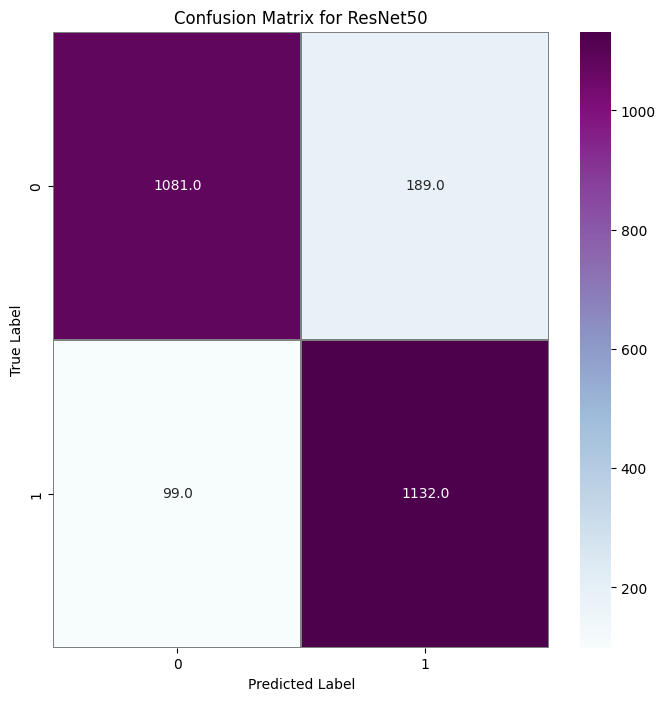

In [18]:
confusion_mtx = confusion_matrix(y_true, y_pred_max) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for ResNet50" )
plt.show()

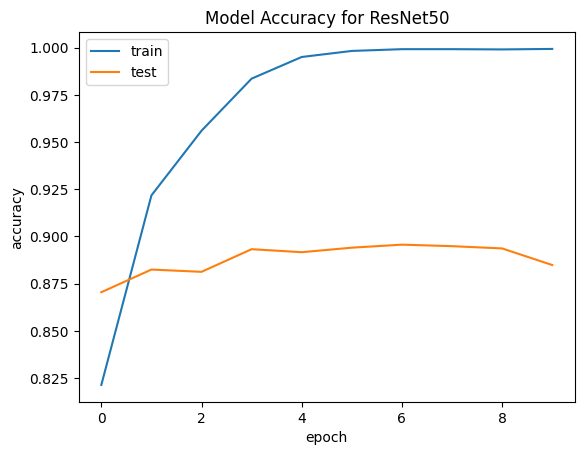

In [19]:
#Plotting training and validation accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy for ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

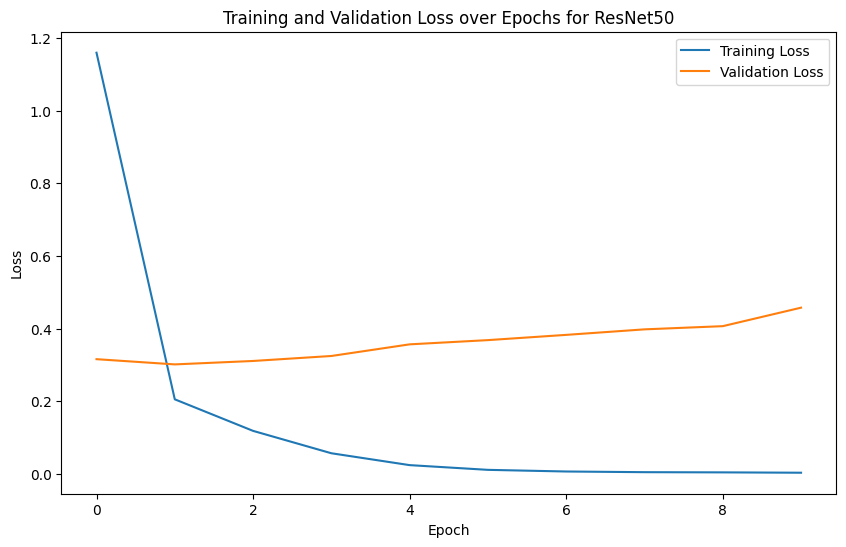

In [27]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs for ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()